# The Child Mind Institute - Detect BFRBs with Sensor Data 

## 1. Background

### 1.1 BFRBs & Child Mental Health

Body‑Focused Repetitive Behaviors (BFRBs) — such as hair pulling, skin picking, nail biting, and cheek/lip biting — are repetitive self‑grooming actions that often harm physical appearance or health. Though sometimes dismissed as “bad habits,” they’re now classified under OCD-related disorders because they frequently serve as involuntary coping mechanisms for anxiety, stress, sensory stimulation, or emotional dysregulation.

In children, BFRBs are especially telling. They often begin in late childhood or early teens and signal underlying emotional or developmental distress. These behaviors can indicate difficulties with impulse control, emotion regulation, and neurocognitive flexibility—making them strong indicators of a child’s mental well-being.

### 1.2 The Helios Wearable

To investigate BFRBs, the Child Mind Institute (CMI) developed a wrist-worn device, Helios, designed to detect these behaviors. While many commercially available devices contain **Inertial Measurement Units (IMUs)** to measure rotation and motion, the Helios watch integrates additional sensors, including: 
* **Thermopiles** - for detecting body heat
* **Time-of-Flight** - for detecting proximity

The CMI conducted a research study to test the added value of these additional sensors for detecting BFRB-like movements.

### 1.3 The Study Protocol

Each participant in the study:
* Performed **18 unique gestures**:
    * 8 BFRB-like gestures
    * 10 non-BFRB-like gestures
* In at least **1 of 4 different body-positions**:
    * Sitting
    * Sitting leaning forward with their non-dominant arm resting on their leg
    * Lying on their back
    * Lying on their side

### 1.4 Competition Objective

Develop a predictive model capable of distinguishing:
1. BFRB-like gestures from non-BFRB-like gestures
2. The specific type of BFRB-like gesture

Crucially, when the model is evaluated, half of the hidden test set only has IMU data, while the other half has all three sensors on the Helios device.

### 1.5 Evaluation Metric

The evaluation metric for this competition is a version of macro F1 that takes an average of binary F1 and macro F1 scores:

* **Binary F1** on whether the `gesture` is one of the target or non-target types
* **Macro F1** on `gesture`, where all non-target sequences are collapsed into a single `non_target` class


## 2. Import Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import set_matplotlib_formats

In [2]:
sns.set(
    style="whitegrid",
    context="notebook",
    rc={
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.facecolor": "white"  
    }
)
%matplotlib inline
%config InlineBackend.figure_format='retina'

## 3. Datasets

Data is separated into two datasets: 
* Sensor data (sen) 
* Demographic and physical characteristics of the participants (dem)

**Import Datasets**

In [3]:
%%time

# Import train and test CSV files
folder_path = '../Inputs/Sensor_Data/'
print('Loading data...')

train_sen_df = pd.read_csv(f'{folder_path}train.csv')
print('\tSuccessfully loaded train_identity!')

train_dem_df = pd.read_csv(f'{folder_path}train_demographics.csv')
print('\tSuccessfully loaded train_demographics!')

test_sen_df  = pd.read_csv(f'{folder_path}test.csv')
print('\tSuccessfully loaded test!')

test_dem_df  = pd.read_csv(f'{folder_path}test_demographics.csv')
print('\tSuccessfully loaded test_demographics!')

print('Data was successfully loaded!\n')

Loading data...
	Successfully loaded train_identity!
	Successfully loaded train_demographics!
	Successfully loaded test!
	Successfully loaded test_demographics!
Data was successfully loaded!

CPU times: user 5.08 s, sys: 478 ms, total: 5.56 s
Wall time: 5.6 s


**Dataset Shapes**

In [4]:
datasets = {
"Train Sensor Data": train_sen_df,
"Train Demographics": train_dem_df,
"Test Sensor Data": test_sen_df,
"Test Demographics": test_dem_df,
}

# Print shapes
for name, df in datasets.items():
    num_rows, num_cols = df.shape
    print(f"{name}:")
    print(f"  Number of Rows: {num_rows}")
    print(f"  Number of Columns: {num_cols}\n")

Train Sensor Data:
  Number of Rows: 574945
  Number of Columns: 341

Train Demographics:
  Number of Rows: 81
  Number of Columns: 8

Test Sensor Data:
  Number of Rows: 107
  Number of Columns: 336

Test Demographics:
  Number of Rows: 2
  Number of Columns: 8



**Merge Sensor Data with Demographic Data**

In [67]:
train_df = pd.merge(train_sen_df, train_dem_df, on='subject', how='left')
test_df  = pd.merge(test_sen_df, test_dem_df, on='subject', how='left')

## 4. Data Exploration

### 4.1 `EDAPlotter` class

In [68]:
class EDAPlotter:
    def __init__(self, train_df, palette=None):
        self.train_df = train_df
        self.palette = palette or {'Non-Target': '#1f77b4', 'Target': '#ff7f0e'} 

    def _annotate_barplot(self, ax, df, orientation='vertical'):
        for bar, (_, row) in zip(ax.patches, df.iterrows()):
            if orientation == 'vertical':
                height = bar.get_height()
                x = bar.get_x() + bar.get_width() / 2
                perc = (height / df['count'].sum()) * 100
                ax.text(x, height + df['count'].sum() * 0.01,
                        f"{perc:.1f}%", va='center', ha='center')
            else:
                width = bar.get_width()
                y = bar.get_y() + bar.get_height() / 2
                perc = (width / df['count'].sum()) * 100
                ax.text(width + df['count'].sum() * 0.0005, y,
                        f"{perc:.1f}%", va='center', ha='left')

    def _style_ax(self, ax, title):
        ax.set_title(title)
        sns.despine(ax=ax)

    def plot_counts(self, df, variable, ax, title, format_axis=True):
        counts = df[variable].value_counts().reset_index().sort_values(variable)

        sns.barplot(data=counts, x=variable, y='count', hue=variable,
                    palette=self.palette, ax=ax)

        self._annotate_barplot(ax, counts, orientation='vertical')
        self._style_ax(ax, title)
        ax.set_ylabel("Count")
        if format_axis:
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y/1000:.0f}k'))

    def plot_grouped_counts(self, df, group_var, target_var, ax, title, format_axis=True):
        counts = df[[group_var, target_var]].value_counts().reset_index()

        sns.barplot(data=counts, x='count', y=target_var, hue=group_var,
                    palette=self.palette, ax=ax)

        self._annotate_barplot(ax, counts, orientation='horizontal')
        self._style_ax(ax, title)
        ax.set_xlabel("Count")
        if format_axis:
            ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1000:.0f}k'))

    def plot_sequence_and_gesture_counts_overall(self):
        fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 3]})

        self.plot_counts(self.train_df, 'sequence_type', axes[0], "Sequence Type Counts")
        self.plot_grouped_counts(self.train_df, 'sequence_type', 'gesture', axes[1], "Gesture Counts by Sequence Type")

        plt.tight_layout()
        plt.show()

    def plot_sequence_and_gesture_counts_by_seq_id(self):
        fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 3]})

        df = self.train_df.groupby('sequence_id').head(1)
        
        self.plot_counts(df, 'sequence_type', axes[0], "Sequence Type Counts", format_axis=False)
        self.plot_grouped_counts(df, 'sequence_type', 'gesture', axes[1], "Gesture Counts by Sequence Type", format_axis=False)

        plt.tight_layout()
        plt.show()

In [69]:
eda = EDAPlotter(train_df)

### 4.2 Target Variable

#### 4.2.1 Overall count

Looking at overall counts, of the 574,945 rows in the data, 60% are target gestures. 
The distribution of gestures is imbalanced so this will need to be accounted for in the training stage.

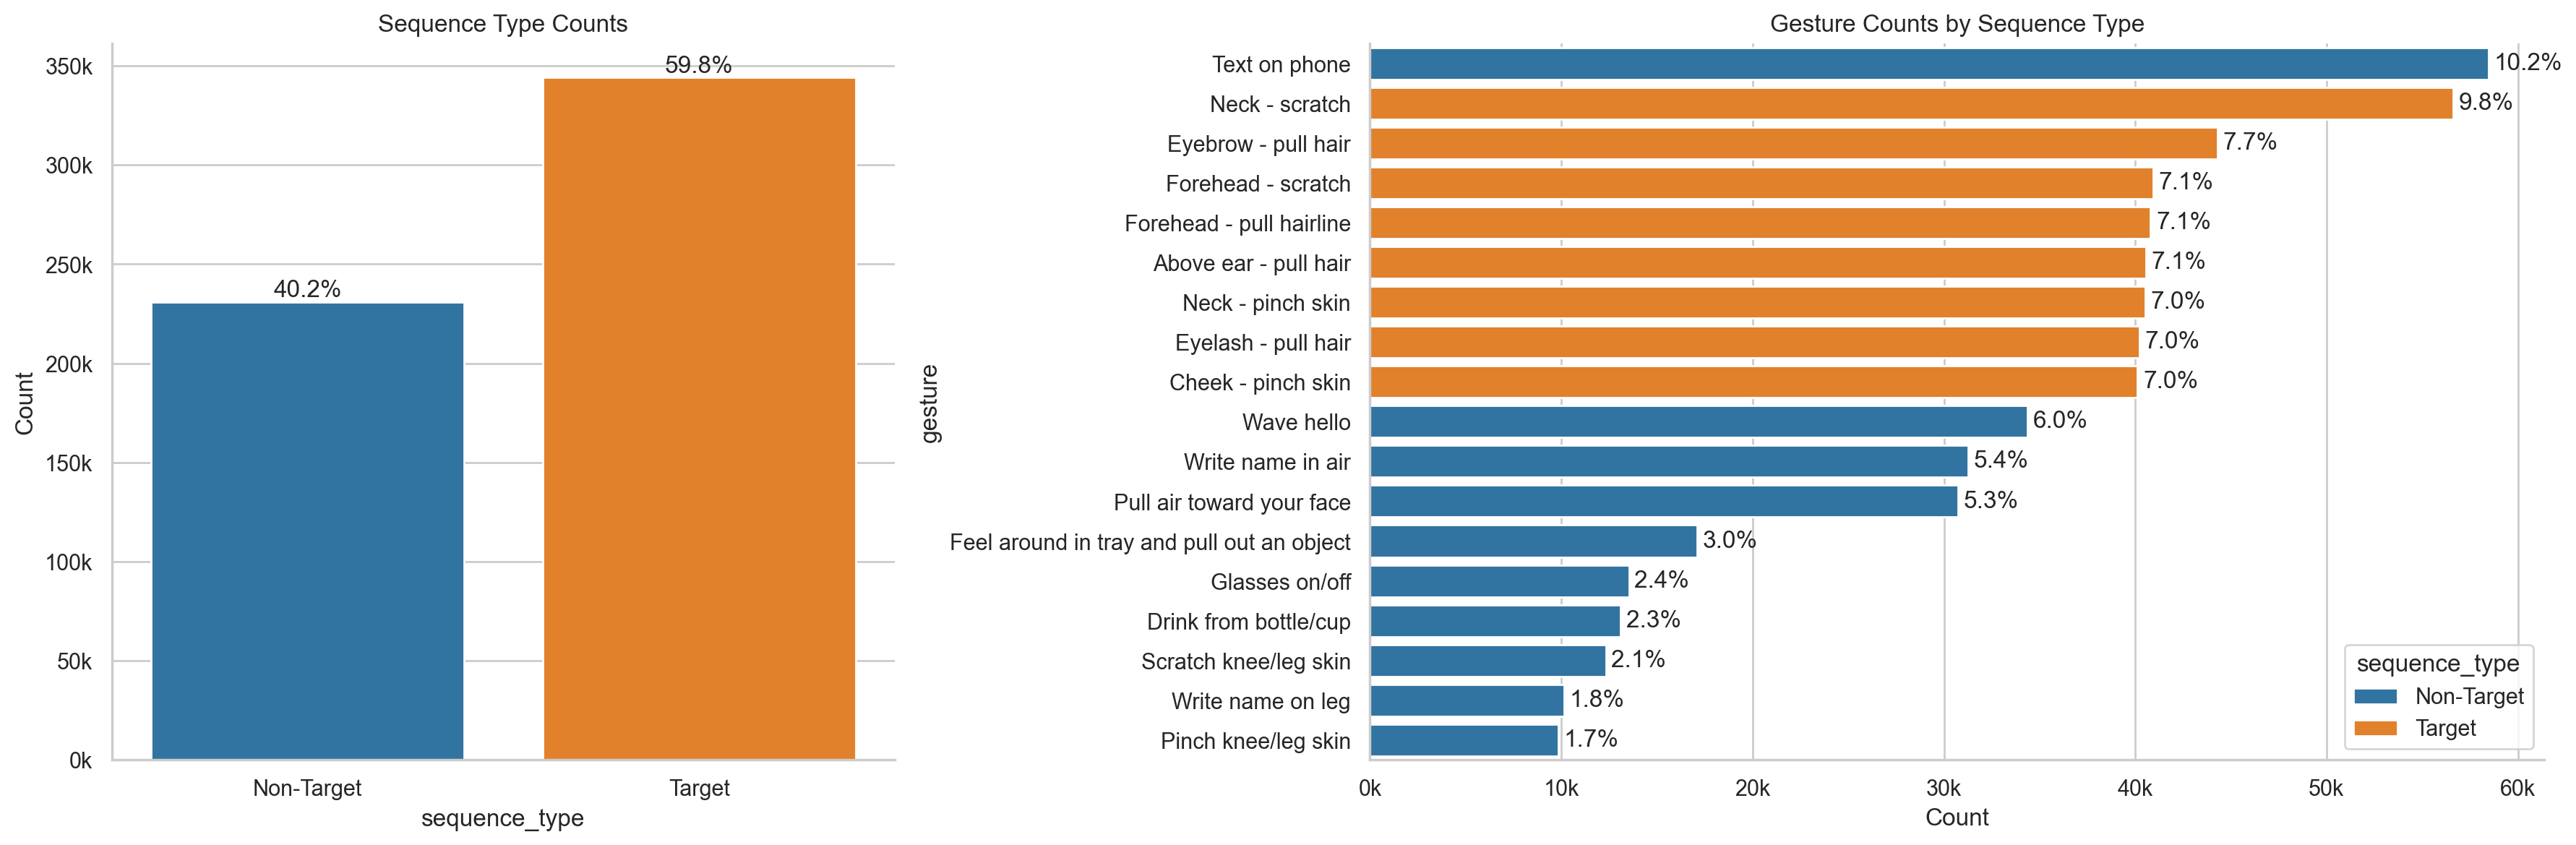

In [70]:
eda.plot_sequence_and_gesture_counts_overall() 

#### 4.2.2 Count by sequence id

Of the 8,151 sequences in the data, 63% are target gestures. The change in gesture distribution tells me that some gestures have a longer sequence length than others. 

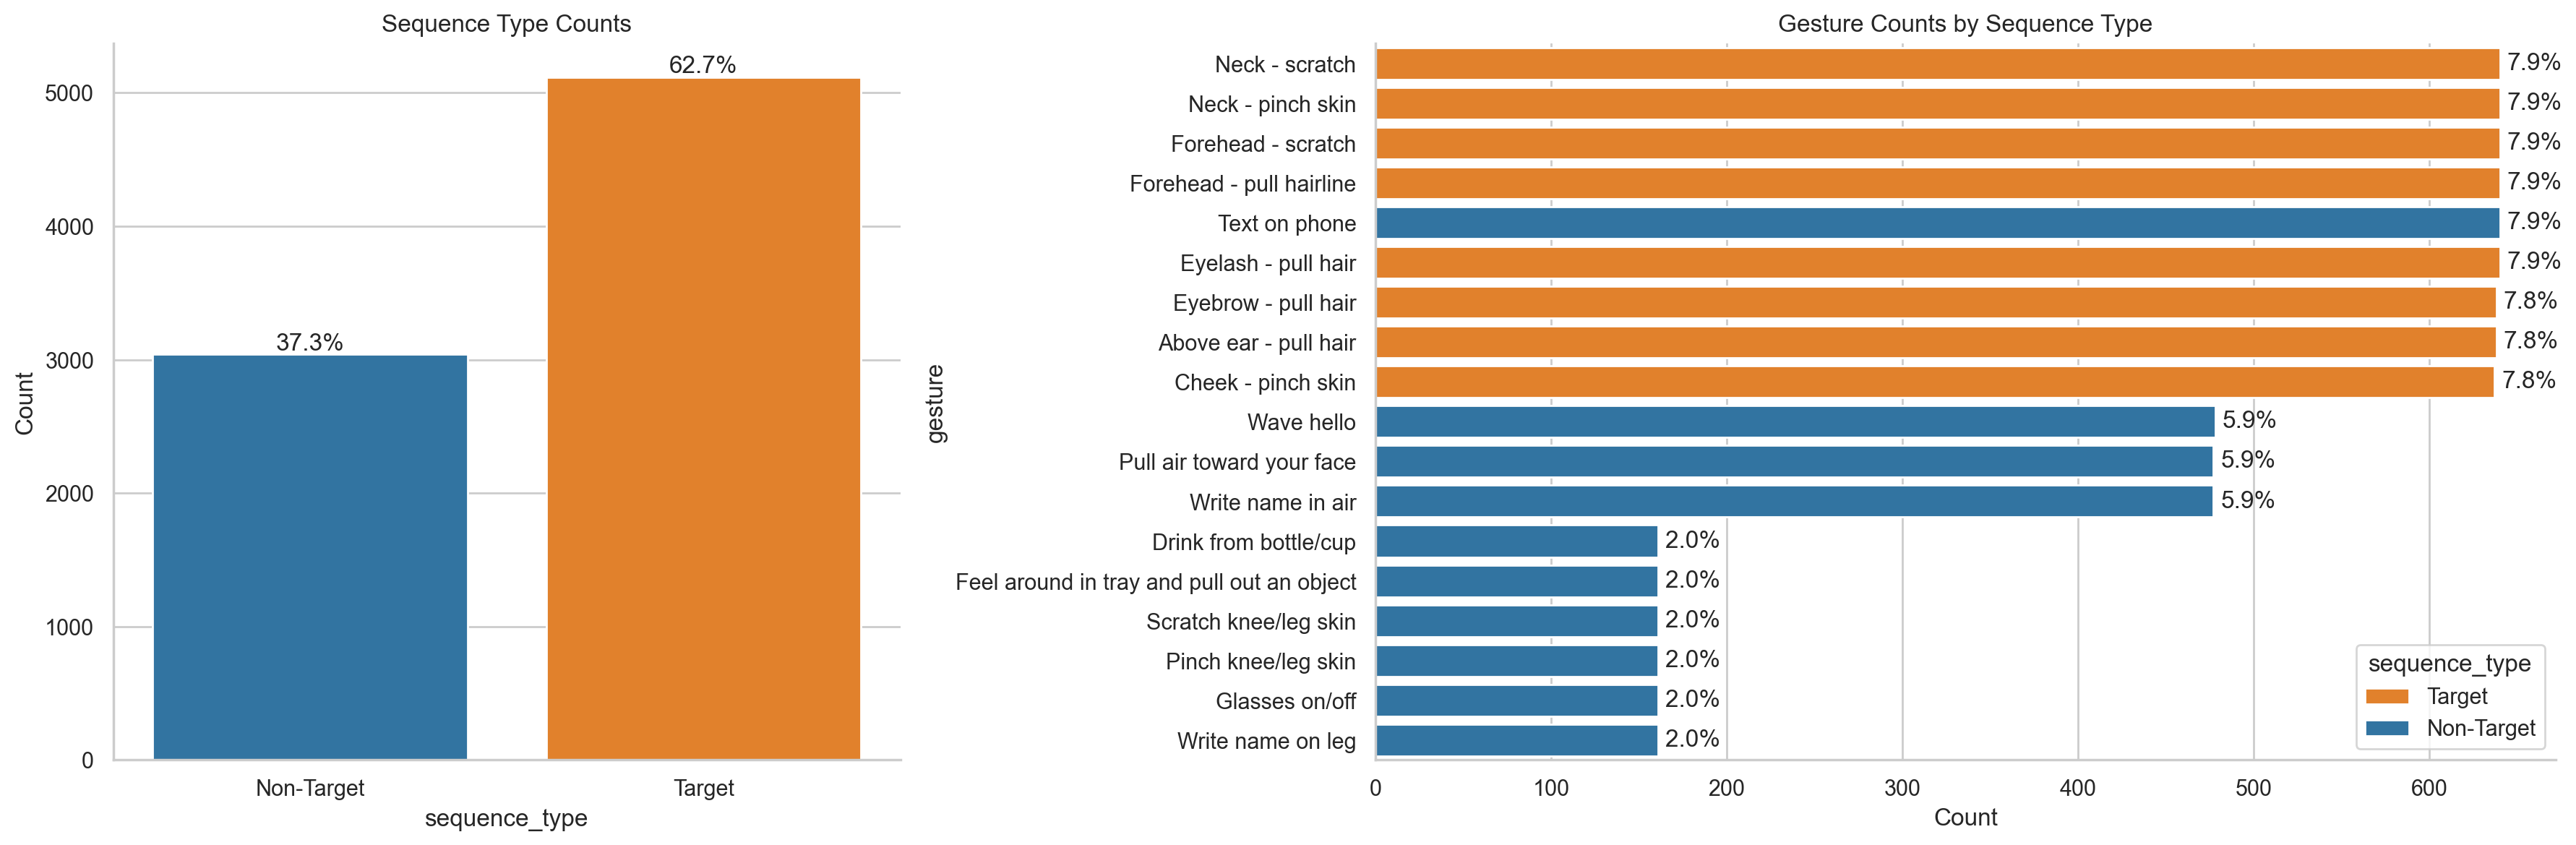

In [59]:
eda.plot_sequence_and_gesture_counts_by_seq_id()

### 4.3 Sensor Data

#### 4.3.1 IMU - acceleration

`acc_[x/y/z]` - Measure linear acceleration along three axes in meters per second squared from the IMU sensor.